![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

# Proporciones de las diferentes clases de variable de interés (y)
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,6089,0.580181
0,4406,0.419819


In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1
import numpy as np
from sklearn import metrics

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]
    
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    j, split, gain = best_split(X, y, num_pct)
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0) 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0: 
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
predictions = tree_predict(X_test, tree)

acctree = metrics.accuracy_score(y_test, predictions)
print("Accuracy Modelo de Árbol Manual: " + str(acctree))

f1tree = metrics.f1_score(y_test, predictions)
print("F1 Modelo de Árbol Manual: " + str(f1tree))

Accuracy Modelo de Árbol Manual: 0.8599884526558892
F1 Modelo de Árbol Manual: 0.8824242424242424


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2
from sklearn.tree import DecisionTreeClassifier

n_estimators = 10
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
samples

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
f1treebag = metrics.f1_score(y_pred, y_test)
acctreebag = metrics.accuracy_score(y_pred, y_test)

print("Accuracy Modelo de Bagging Manual: " + str(acctreebag))

print("F1 Modelo de Bagging Manual: " + str(f1treebag))


Accuracy Modelo de Bagging Manual: 0.8524826789838337
F1 Modelo de Bagging Manual: 0.8755782809836863


### Comentarios del modelo

Es interesante notar que tanto el Accuracy y el F1 del modelo Bagging son inferiores a los obtenidos con el Árbol de decisión manual. La vitación mayoritaria definida en este modelo no esta pudiendo sobrepasar el performance obtenido por un solo árbol de decisión. Probablemente se deba realizar una Votación Ponderada para tratar de que los modelos que menos se equivocan sean tenidos más en cuenta y así se pueda mejorar el desempeño de este ensamble.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [7]:
# Celda 3
from sklearn.ensemble import BaggingClassifier

max_features_cal = int(np.log2(len(X_train.columns)))

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features = max_features_cal), n_estimators=n_estimators, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, )

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1treebag2 = metrics.f1_score(y_pred, y_test)
acctreebag2 = metrics.accuracy_score(y_pred, y_test)


print("Accuracy Modelo de Bagging Librería: " + str(acctreebag2))
print("F1 Modelo de Bagging Librería: " + str(f1treebag2))

Accuracy Modelo de Bagging Librería: 0.8455542725173211
F1 Modelo de Bagging Librería: 0.8670146656723838


### Comentarios del modelo

El Accuraccy y el F1 del modelo Bagging con librería son muy similares a los obtenidos con el modelo de Bagging Manual. Nuevamente se obtienen valores de Accuracy y de F1 cercanos al 85%. Lo más destacado en esta implementación es que estamos usando, para cada nodo, un máximo de log2 número de predictores para definir el mejor split.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

Accuracy Modelo de Random Forest Librería: 0.8438221709006929
F1 Modelo de Random Forest Librería: 0.8667159398866716


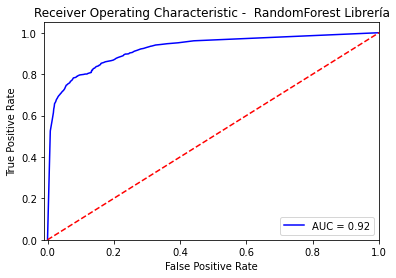

In [8]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

f1rf = metrics.f1_score(y_pred, y_test)
accrf = metrics.accuracy_score(y_pred, y_test)

print("Accuracy Modelo de Random Forest Librería: " + str(accrf))
print("F1 Modelo de Random Forest Librería: " + str(f1rf))

prediccionRF_prob=clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionRF_prob, pos_label=0)
AUCRF1=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic -  RandomForest Librería')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRF1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comentarios del modelo

El Accuracy y el F1 del modelo Random Forest con librería son muy similares a los obtenidos con ambos modelos de Bagging. Lo más destacado en esta implementación es su sencillez. Con un par de líneas y sin calibrar ningún parámetro, se esta logrando un valor cercano al 85% para el Accuracy y el F1. Adicionalmente se ha incluido una curva AUC con un valor de 0.92, lo cual ratifica el buen desempeño de este modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

(0.8395737019914652, 30)

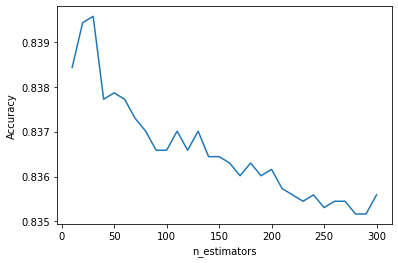

In [9]:
# Celda 5

estimator_range = range(10, 310, 10)

accuracy_scores = []

for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.8502396385620068, 9)

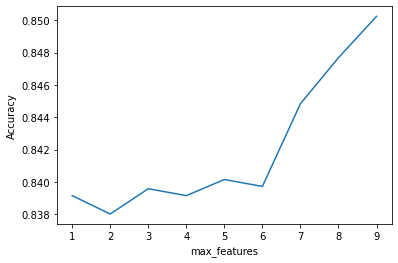

In [10]:
feature_range = range(1, len(X_train.columns)+1)

accuracy_scores = []

for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=30, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, feature_range))[::-1][0]

(0.8808161855036856, 6)

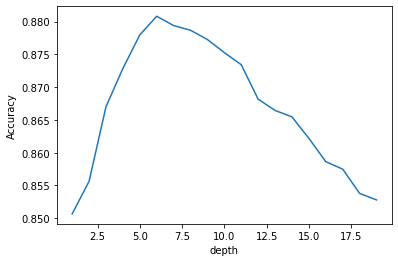

In [11]:
depth_range = range(1, 20, 1)

accuracy_scores = []

for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=30, max_features = 9, max_depth = depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(depth_range, accuracy_scores)
plt.xlabel('depth')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, depth_range))[::-1][0]

Accuracy Modelo de Random Forest Calibrado: 0.8937644341801386
F1 Modelo de Random Forest Calibrado: 0.9120038259206121


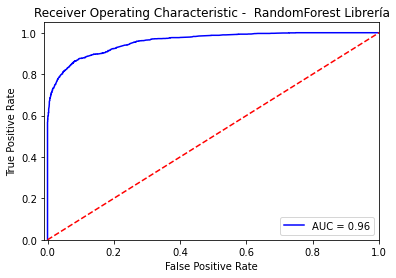

In [12]:
clf = RandomForestClassifier(n_estimators=30, max_features=9, max_depth = 6, random_state=1, n_jobs=-1)
clf.fit(X, y)

y_pred = clf.predict(X_test)

f1rf2 = metrics.f1_score(y_pred, y_test)
accrf2 = metrics.accuracy_score(y_pred, y_test)

print("Accuracy Modelo de Random Forest Calibrado: " + str(accrf2))
print("F1 Modelo de Random Forest Calibrado: " + str(f1rf2))

prediccionRF_prob=clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionRF_prob, pos_label=0)
AUCRF2=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic -  RandomForest Librería')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRF2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Comentarios del modelo

El Accuracy y el F1 del modelo Random Forest calibrado comienzan a mostrar las primeras mejoras significativas de este ejercicio. Se ha decidido hacer una calibración individual de parámetros con el fin de obtener tiempos cortos de ejecución (es claro que de esta forma no se obtiene necesariamente el mejor performance). Los parámetros elegidos para la calibración y su significado en el modelo son los siguientes:

- n_estimators: Random Forest es un modelo de ensamble. Por lo que requiere la construcción de múltiples modelos para despues consolidar los resultados/predicciones de los mismos. El parámetro n_estimators define el número de árboles a ser construidos en el ensamble, siendo en este caso 30 el valor que mejor resultado da a nivel de performance.

- max_features: Número de columnas/features a ser tenidas en cuenta por cada split (Nodo). En puntos anteriores, usamos log2 para este valor. Para Random Forest, la calibración nos indica que el mejor performance se obtiene al utilizar siempre la totalidad de las columnas en cada partición. Esto puede deberse a que se tienen muy pocas columnas en el dataset de entrada y a sus interacciones con la variable predictora.

- max_depth: La máxima profundidad permitida en los árboles del ensamblaje desde el nodo raíz hasta las hojas. La calibración indica que el performance es máximo con una profundidad de 6.

Adicionalmente se ha incluido una curva AUC con un valor de 0.96, lo cual ratifica el buen desempeño de este modelo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

Accuracy Modelo de XGBoost: 0.8856812933025404
F1 Modelo de XGBoost: 0.9047160731472569


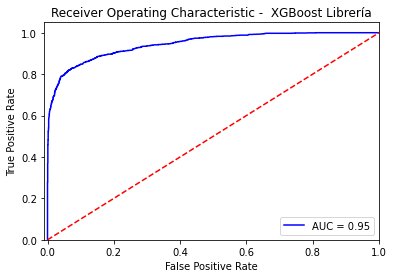

In [13]:
# Celda 6
from xgboost import XGBClassifier
clf = XGBClassifier(eval_metric='auc')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1xg = metrics.f1_score(y_pred, y_test.values)
accxg = metrics.accuracy_score(y_pred, y_test.values)

print("Accuracy Modelo de XGBoost: " + str(accxg))
print("F1 Modelo de XGBoost: " + str(f1xg))

prediccionRF_prob=clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionRF_prob, pos_label=0)
AUCXG1=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic -  XGBoost Librería')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCXG1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comentarios del modelo

El Accuracy y el F1 del modelo XGBoost con librería son muy similares a los obtenidos con Random Forest calibrado, lo cual destaca su poder predictivo. Lo más destacado en esta implementación es su sencillez. Con un par de líneas y sin calibrar ningún parámetro, se está logrando obtener casi los mismos resultados de un modelo calibrado. Adicionalmente se ha incluido una curva AUC con un valor de 0.95, lo cual ratifica el buen desempeño de este modelo.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

(0.8815272210009052, 0.05099999999999999)

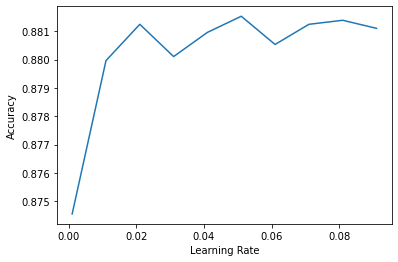

In [14]:
# Celda 7
import warnings
warnings.filterwarnings('ignore')

learRate_range = np.arange(0.001, 0.1, 0.01)

accuracy_scores = []

for lr in learRate_range:
    clf = XGBClassifier(learning_rate = lr, random_state=1, n_jobs=-1, eval_metric='auc')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(learRate_range, accuracy_scores)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, learRate_range))[::-1][0]


(0.8818123221906117, 5)

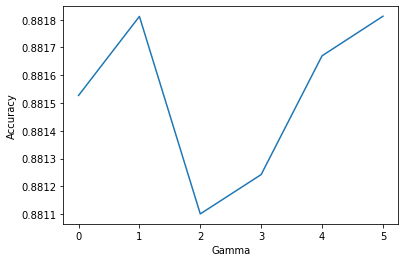

In [15]:
gamma_range = range(0, 6, 1)

accuracy_scores = []

for g in gamma_range:
    clf = XGBClassifier(learning_rate = 0.051, gamma = g,  random_state=1, n_jobs=-1, eval_metric='auc')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(gamma_range, accuracy_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, gamma_range))[::-1][0]

(0.8840880803051856, 0.6)

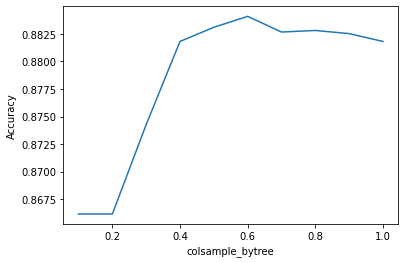

In [16]:
colsample_bytree_range = np.arange(0.1, 1.1, 0.1)

accuracy_scores = []

for csbt in colsample_bytree_range:
    clf = XGBClassifier(learning_rate = 0.051, gamma = 5, colsample_bytree = csbt, random_state=1, n_jobs=-1, eval_metric='auc')
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

sorted(zip(accuracy_scores, colsample_bytree_range))[::-1][0]

Accuracy Modelo XGBoost Calibrado: 0.8911662817551963
F1 Modelo XGBoost Calibrado: 0.9102594620328492


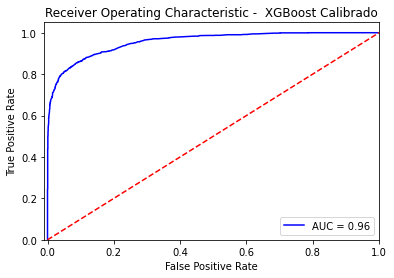

In [17]:
clf = XGBClassifier(learning_rate = 0.051, gamma = 5, colsample_bytree = 0.6, random_state=1, n_jobs=-1, eval_metric='auc')
clf.fit(X, y)

y_pred = clf.predict(X_test)

f1xgcal = metrics.f1_score(y_pred, y_test)
accxgcal = metrics.accuracy_score(y_pred, y_test)

print("Accuracy Modelo XGBoost Calibrado: " + str(accxgcal))
print("F1 Modelo XGBoost Calibrado: " + str(f1xgcal))

prediccionRF_prob=clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionRF_prob, pos_label=0)
AUCXG2=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic -  XGBoost Calibrado')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCXG2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comentarios del modelo

Se realiza una calibración sobre el modelo de XGBoost y se obtienen mejoras sobre el modelo no calibrado, aunque estas son menos significativas que las logradas, por ejemplo, con la calibración realizada con Random Forest y su par sin calibrar. Los tiempos de calibración son sensiblemente más altos que los experimentados con Random Forest para cada parámetro. Aquí calibramos:

- learning_rate: Controla el peso de los nuevos árboles añadidos al ensamble. Se prefieren usualmente valores bajos. Para este ejercicio, el valor encontrado como óptimo es de 0.051.

- gamma: Parámetro de regularización (reducción de perdida mínima para hacer un split) que usualmente toma valores de 0, 1 o 5. Se itera entre 0 y 5 para determinar el mejor performance que en este caso se logra con 5.

- colsample_bytree: Número de columnas usadas para cada árbol. Si se tienen pocas columnas, usualmente se utiliza el valor de 1. Si se tienen muchas columnas, se prefieren valores entre 0.3 y 0.8. Esto con el fin de que algunas columnas tomen mucho crédito en cada predicción y sean casi siempre las mismas usadas por los árboles. En este ejercicio el valor seleccionado fue de 0.6.

Adicionalmente se ha incluido una curva AUC con un valor de 0.96, lo cual ratifica el buen desempeño de este modelo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

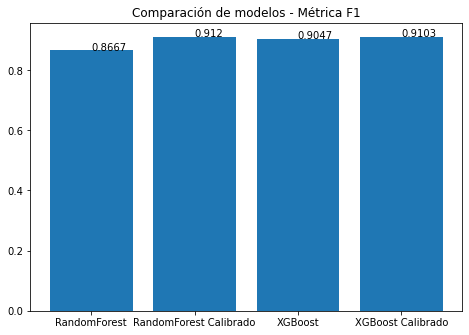

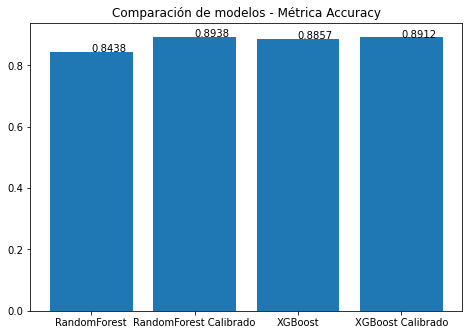

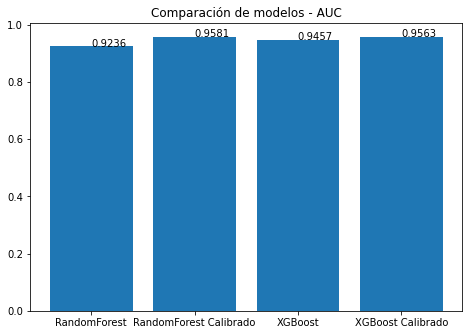

In [18]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos - Métrica F1")
ejeX = ['RandomForest', 'RandomForest Calibrado','XGBoost', 'XGBoost Calibrado']
ejeY = [f1rf, f1rf2, f1xg, f1xgcal]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,round(y[i], 4), round(y[i], 4))
addlabels(ejeX,ejeY,plt)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos - Métrica Accuracy")
ejeX = ['RandomForest','RandomForest Calibrado','XGBoost', 'XGBoost Calibrado']
ejeY = [accrf, accrf2, accxg, accxgcal]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,round(y[i], 4), round(y[i], 4))
addlabels(ejeX,ejeY,plt)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos - AUC")
ejeX = ['RandomForest','RandomForest Calibrado','XGBoost', 'XGBoost Calibrado']
ejeY = [AUCRF1, AUCRF2, AUCXG1, AUCXG2]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,round(y[i], 4), round(y[i], 4))
addlabels(ejeX,ejeY,plt)
plt.show()

### Conclusiones Finales:

- La calibración es fundamental para obtener un mejor desempeño si se la compara con el que puede ser obtenida con los modelos básicos.
- El mejor modelo es Random Forest calibrado, aunque las diferencias respecto a XGBoost calibrado son mínimas.
- Las principales ventajas de usar RandomForest es que muchos de los parámetros usados en su calibración son los mismos que se usarían para calibrar un único árbol (facilidad de uso) y a que los tiempos requeridos para su calibración fueron un poco menores a los necesarios para calibrar XGBoost.
- Por otra parte, el modelo con menor rendimiento fue el Random Forest sin calibrar. A pesar de su facilidad para ser implementado (solo requiere un par de líneas de código) su principal falencia fue su bajo rendimiento en comparación de los demás ensambles. No logró obtener un buen rendimiento en ninguno de los criterios de evaluación.
- Mención especial a las diferencias sutiles existentes entre el Accuracy y el F1 Score. En este caso, la métrica que debe imperar sobre la otra depende en gran medida de que es más costoso para la organización (si un error tipo 1 o tipo 2). Si los costos son iguales, se puede usar Accuracy (y asumiendo que ambas clases estan balanceadas. Vimos en principio que estan casi en un 60/40 por lo cual e6 desbalanceo no es muy marcado). Si para la organización es mas relevante alguno de los dos errores, es mejor usar F1 Score, ya que este tiene en cuenta los errores Tipo I y Tipo II para su cálculo (recall).

### Fuentes:
- [XGBoost](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)
- [Learning Rate](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/)
- [F1 Score](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/#:~:text=F1%20score%20%2D%20F1%20Score%20is,and%20false%20negatives%20into%20account.)